In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "./data"

label_maps = {
    0.0: "background",
    205.0: "the myocardium of the left ventricle",
    420.0: "the left atrium blood cavity",
    500.0: "the left ventricle blood cavity",
    550.0: "the right atrium blood cavity",
    600.0: "the right ventricle blood cavity",
    820.0: "the ascending aorta",
    850.0: "the pulmonary artery",
}

In [2]:
import os
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None, prefix="", postfix=""):

        self.inputs_paths = []
        self.targets_paths = []

        for path in os.listdir(image_dir):
            if path.startswith(prefix) and path.endswith(f"_image.nii.npy{postfix}"):
                self.inputs_paths.append(os.path.join(image_dir, path))
                
        for path in os.listdir(label_dir):
            if path.startswith(prefix) and path.endswith(f"_label.nii.npy{postfix}"):
                self.targets_paths.append(os.path.join(label_dir, path))

        if len(self.inputs_paths) != len(self.targets_paths):
            raise ValueError(f"Inputs and targets have different lengths: {len(self.inputs_paths)} vs {len(self.targets_paths)}")
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.inputs_paths)
    
    def __getitem__(self, idx):
        image_path = self.inputs_paths[idx]
        label_path = self.targets_paths[idx]

        image : np.ndarray = np.load(image_path)
        label : np.ndarray = np.load(label_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
from torchvision import transforms

class ImagePreprocessing(object):
    def __call__(self, image):
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image).type(torch.FloatTensor).to(device)
        return image

class LabelPreprocessing(object):
    def __init__(self, label_values):
        self.label_values = label_values

    def __call__(self, label):
        values = self.label_values
        processed_label = np.zeros(shape=(len(values), *label.shape), dtype=np.float32)
        for i, value in enumerate(values):
            processed_label[i] = np.where(label == value, 1.0, 0.0)
        # processed_label = np.expand_dims(processed_label, axis=0)
        processed_label = torch.from_numpy(processed_label).type(torch.FloatTensor).to(device)
        return processed_label
    
train_dataset = Dataset(
    os.path.join(DATA_PATH, "train"),
    os.path.join(DATA_PATH, "train"),
    transform=transforms.Compose([
                                #   transforms.ToTensor(),
                                  ImagePreprocessing()
                                  ]),
    target_transform=transforms.Compose(transforms=[
                                        # transforms.ToTensor(),
                                        LabelPreprocessing(list(label_maps.keys()))]),
    postfix=".256256128.npy"
)

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [5]:
import mmwhs_model
hparams = {
        'n_channels':1,
        'n_classes':8,
    }
model = mmwhs_model.Unet3D(None, train_loader, hparams)
checkpoint_file = torch.load('checkpoints/mmwhs_v1.ckpt', weights_only=False)
# model.load_state_dict(torch.load('checkpoints/mmwhs_v1.pth', weights_only=False))
model.load_state_dict(checkpoint_file['state_dict'])
model = model.to(device)

{'n_channels': 1, 'n_classes': 8}


In [17]:
from tabulate import tabulate
label_names = [value for value in label_maps.values()]
metrics_table = [ ["", *label_names, "mean"] ]

def label_postprocessing(label: torch.Tensor):
    label = torch.softmax(label, dim=1).argmax(dim=1).to("cpu").squeeze(0)
    label_values = list(range(8))
    processed_label = torch.zeros(size=(len(label_values), *label.shape), dtype=torch.int32)
    for i, value in enumerate(label_values):
        processed_label[i] = torch.where(label == value, 1, 0)

    return processed_label

class Metrics:
    """
    outputs : torch.Tensor (batch_size, n_classes, x_dim, y_dim, z_dim)
    targets : torch.Tensor (batch_size, n_classes, x_dim, y_dim, z_dim)
    """
    def __init__(self, outputs : torch.Tensor, targets : torch.Tensor, smooth=1e-6):
        assert outputs.shape == targets.shape

        self.smooth = smooth

        self.intersection = (outputs & targets).float().sum((1, 2, 3))
        self.union = (outputs | targets).float().sum((1, 2, 3))

    def pixel_accuracy(self):
        # TODO
        pass

    def mean_pixel_accuracy(self):
        # TODO
        pass

    def IoU(self):
        return self.intersection / (self.union + self.smooth)
    
    def meanIoU(self):
        return torch.mean(self.IoU())
    
    def Dice(self):
        return (2 * self.intersection) / (self.union + self.intersection + self.smooth)
    
    def meanDice(self):
        return torch.mean(self.Dice())


# torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    import itertools
    for i, (inputs, targets) in enumerate(itertools.islice(train_loader, 3)):
        outputs = model(inputs)
        outputs = label_postprocessing(outputs)
        targets = targets.int().squeeze(0).to("cpu")
        metrics = Metrics(outputs, targets)
        
        metrics_table.append([f"{i}"])
        iou = metrics.IoU().numpy()
        mean_iou = metrics.meanIoU().numpy()
        metrics_table.append(["IoU", *iou, mean_iou])
        dice = metrics.Dice().numpy()
        mean_dice = metrics.meanDice().numpy()
        metrics_table.append(["Dice", *dice, mean_dice])
        
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid", numalign="center"))

╒══════╤══════════════╤════════════════════════════════════════╤════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════════╤════════════════════════════════════╤═══════════════════════╤════════════════════════╤══════════╕
│      │  background  │  the myocardium of the left ventricle  │  the left atrium blood cavity  │  the left ventricle blood cavity  │  the right atrium blood cavity  │  the right ventricle blood cavity  │  the ascending aorta  │  the pulmonary artery  │   mean   │
╞══════╪══════════════╪════════════════════════════════════════╪════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════════╪════════════════════════════════════╪═══════════════════════╪════════════════════════╪══════════╡
│ 0    │              │                                        │                                │                                   │                                 │                                    │ 

In [7]:
with torch.no_grad():
    model.eval()
    z = next(iter(train_loader))
    z_pred = model(z[0]).cpu()
    z_pred = torch.softmax(z_pred, dim=1).argmax(dim=1).squeeze(0).numpy()

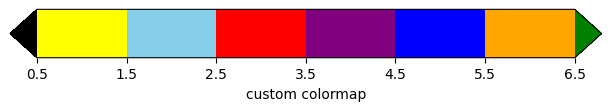

In [8]:
# make custom colormap
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt

color_dict = {
               "black": [0, "background"],
               "yellow": [1, "the myocardium of the left ventricle"],
               "skyblue": [2, "the left atrium blood cavity"],
               "red": [3, "the left ventricle blood cavity"],
               "purple": [4, "the right atrium blood cavity"],
               "blue": [5, "the right ventricle blood cavity"],
               "orange": [6, "the ascending aorta"],
               "green": [7, "the pulmonary artery"],
}
pixel_values = [value[0] for value in color_dict.values()]
colors = color_dict.keys()

mid_bounds = [(pixel_values[i] + pixel_values[i+1]) / 2 for i in range(len(pixel_values)-1)]
custom_cmap = matplotlib.colors.ListedColormap(list(colors)[1:], N=len(colors)).with_extremes(under='black', over='green')
norm = matplotlib.colors.BoundaryNorm(mid_bounds, custom_cmap.N - 2)

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=custom_cmap, norm=norm),
    cax=ax, orientation='horizontal',
    extend='both',
    spacing='proportional',
    label='custom colormap',
)

In [22]:
z[0].cpu().squeeze().T.shape

torch.Size([128, 256, 256])

Text(0.5, 1.0, 'Target')

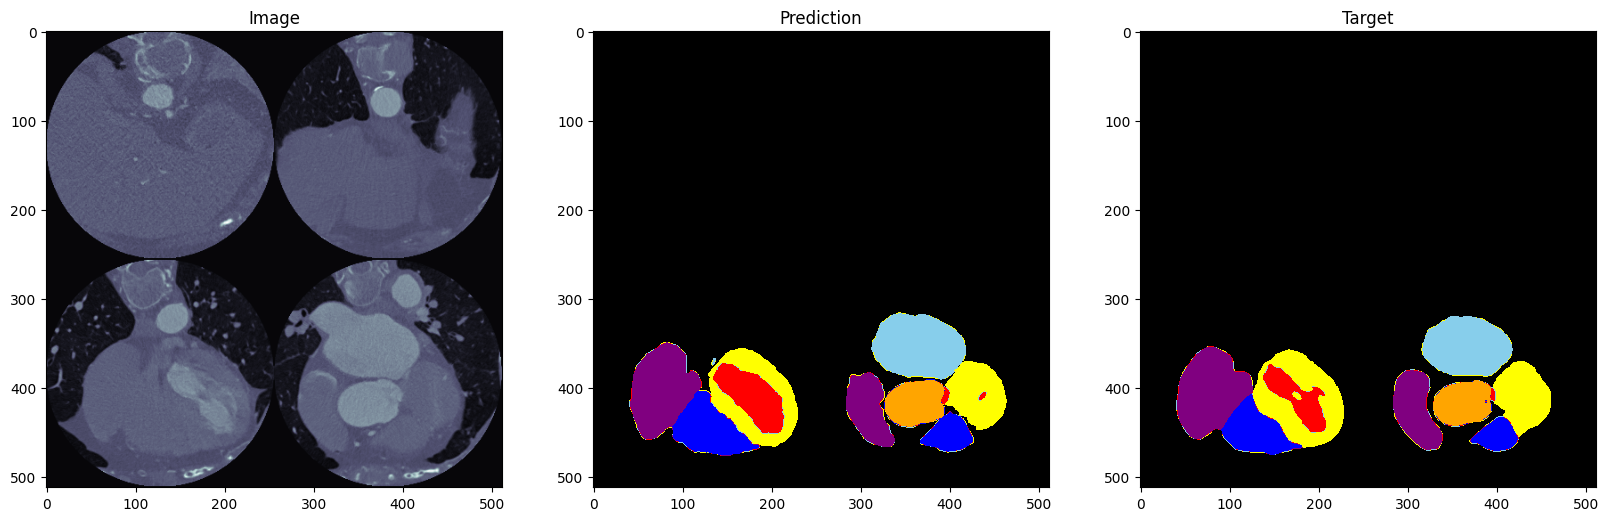

In [26]:
import skimage
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax[0].imshow(skimage.util.montage(z[0].cpu().squeeze().T[:100:25]), cmap="bone")
ax[1].imshow(skimage.util.montage(torch.softmax(z[1], dim=1).argmax(dim=1).cpu().squeeze(0).numpy().T[:100:25]), cmap=custom_cmap, norm=norm)
ax[2].imshow(skimage.util.montage(z_pred.T[:100:25]), cmap=custom_cmap, norm=norm)
ax[0].set_title("Image")
ax[1].set_title("Prediction")
ax[2].set_title("Target")

In [11]:
import vtk

def vtk_visualize_3d_numpy_array(data : np.ndarray, cmap, pixel_values: list, apply_cfilter: bool = False):
    vtk_data = vtk.vtkImageData()
    vtk_data.SetDimensions(data.shape)
    vtk_data.SetSpacing([1, 1, 1])
    vtk_data.SetOrigin([0, 0, 0])
    vtk_data.AllocateScalars(vtk.VTK_INT, 1)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                vtk_data.SetScalarComponentFromFloat(i, j, k, 0, data[i, j, k])

    image = vtk_data

    actors = []
    pixel_values = pixel_values[1:]
    renderer = vtk.vtkRenderer()
    for i in range(len(pixel_values)):

        marching_cubes = vtk.vtkDiscreteMarchingCubes()
        marching_cubes.SetInputData(image)
        marching_cubes.SetValue(0, pixel_values[i])
        marching_cubes.Update()
        mc_image = marching_cubes.GetOutputPort()

        if apply_cfilter:
            confilter = vtk.vtkPolyDataConnectivityFilter()
            confilter.SetInputConnection(mc_image)
            confilter.SetExtractionModeToLargestRegion()
            confilter.Update()
            mc_image = confilter.GetOutputPort()

        lookup_table = vtk.vtkLookupTable()
        lookup_table.SetNumberOfTableValues(1)
        lookup_table.Build()
        val = vtk.vtkNamedColors().GetColor3d(cmap.colors[i])
        lookup_table.SetTableValue(0, val[0], val[1], val[2], 1.0)

        mapper = vtk.vtkPolyDataMapper()
        mapper.AddInputConnection(mc_image)
        mapper.SetLookupTable(lookup_table)
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)

        actors.append(actor)

        renderer.AddActor(actors[-1])

    window = vtk.vtkRenderWindow()
    window.AddRenderer(renderer)

    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(window)
    interactor.Initialize()
    renderer.Render()
    window.Render()
    interactor.Start()

vtk_visualize_3d_numpy_array(z_pred, cmap=custom_cmap, pixel_values=pixel_values)